# generic bucketing framework

Framework for bucketing season-level performance and game-level performance into an arbitrary amount of buckets. The idea is to use this to feel out whether some sort of generic bucketing scheme is appropriate to use as a first pass at a predictive model for player performance, and if so, which bucket distribution is most appropriate?

In [1]:
# stuff we need
import math
import matplotlib.pyplot as plt
import petl
import psycopg2

from lombardi import bayes


# big inline graphs by default
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# suppress bullshit scipy warnings
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# global connection for db
conn = psycopg2.connect('dbname=nfldb')

## define functions for bucketing season/game performance

In [3]:
def season_buckets(season_param, season_bins):
    
    # extract data
    full_seasons = petl.fromdb(conn, 'select * from lombardi.qb_aggs').selecteq('num_games', 16)
    
    vals = [float(y) for y in full_seasons[season_param]]

    # calculate params for our model
    min_v = min(vals)
    max_v = max(vals)
    bin_size = (max_v-min_v)/season_bins
    
    def rebucket(v):
        if v == season_bins:
            return v-1
        return v
    
    # bucket vals
    seasons = (
        full_seasons
        .addfield('normed_v', lambda r: float(r[season_param]) - min_v)
        .addfield('bucket', lambda r: int(r['normed_v'] // bin_size))
        .convert(season_param, float)
        # gnarly hack to account for bin logic weirdness on last value
        .convert('bucket', rebucket)
        .cut(('year', 'name', season_param, 'bucket'))
    )
    
    return seasons

In [4]:
def game_buckets(game_param, game_bins):
    
    # extract data
    qb_games = petl.fromdb(conn, 'select * from lombardi.qb_stats')
    
    vals = [float(y) for y in qb_games[game_param]]
    
    # calculate params for our model
    min_v = min(vals)
    max_v = max(vals)
    bin_size = (max_v-min_v)/game_bins
    
    def rebucket(v):
        if v == game_bins:
            return v-1
        return v
    
    # bucket vals
    games = (
        qb_games
        .addfield('normed_v', lambda r: float(r[game_param]) - min_v)
        .addfield('bucket', lambda r: int(r['normed_v'] // bin_size))
        .convert(game_param, float)
        # gnarly hack to account for bin logic weirdness on last value
        .convert('bucket', rebucket)
        .cut(('year', 'name', 'week', game_param, 'bucket'))
    )
    
    return games

In [12]:
# get explicit probability distributions
def bucket_dist(table):
    agg = table.aggregate('bucket', len)
    tot = sum(agg['value'])
    probs = agg.addfield('prob', lambda r: r['value'] / tot)
    return probs

# set parameters for bucket logic

For now, split season performance (aka QB quality) into three buckets (bad, okay, elite) and game performance into five buckets.

In [14]:
season_bins = 3
game_bins = 5

season_param = 'avg_yds'
game_param = 'yards'

## bucket season/game performance

In [15]:
gbs = game_buckets('yards', 5)
gbs.look()

+------+----------------------+------+-------+--------+
| year | name                 | week | yards | bucket |
+======+======================+======+=======+========+
| 2009 | 'Aaron Rodgers'      |    1 | 184.0 |      1 |
+------+----------------------+------+-------+--------+
| 2009 | 'Ben Roethlisberger' |    1 | 363.0 |      3 |
+------+----------------------+------+-------+--------+
| 2009 | 'Carson Palmer'      |    1 | 247.0 |      2 |
+------+----------------------+------+-------+--------+
| 2009 | 'Drew Brees'         |    1 | 358.0 |      3 |
+------+----------------------+------+-------+--------+
| 2009 | 'Eli Manning'        |    1 | 256.0 |      2 |
+------+----------------------+------+-------+--------+
...

(array([  224.,   771.,  1152.,   423.,    38.]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <a list of 5 Patch objects>)

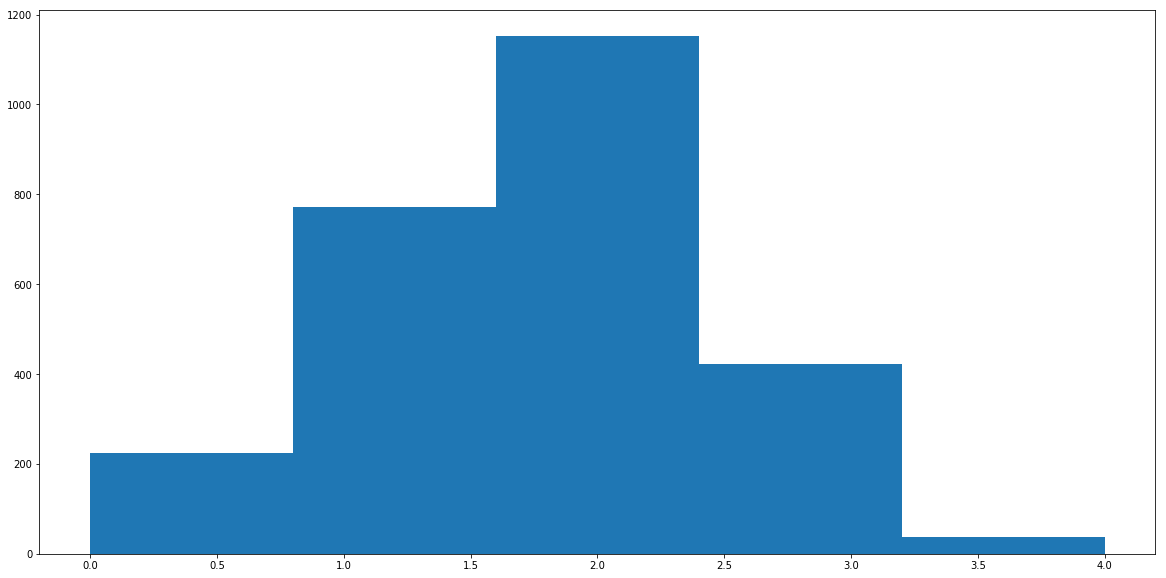

In [16]:
plt.hist(gbs['bucket'], bins=5)

In [17]:
sbs = season_buckets('avg_yds', 3)
sbs.look()

+------+-----------------+---------+--------+
| year | name            | avg_yds | bucket |
+======+=================+=========+========+
| 2009 | 'Aaron Rodgers' |  277.13 |      1 |
+------+-----------------+---------+--------+
| 2009 | 'Carson Palmer' |  193.38 |      0 |
+------+-----------------+---------+--------+
| 2009 | 'Eli Manning'   |  251.31 |      1 |
+------+-----------------+---------+--------+
| 2009 | 'Joe Flacco'    |  225.81 |      0 |
+------+-----------------+---------+--------+
| 2009 | 'Matt Schaub'   |  298.13 |      2 |
+------+-----------------+---------+--------+
...

(array([ 31.,  44.,  15.]),
 array([ 0.        ,  0.66666667,  1.33333333,  2.        ]),
 <a list of 3 Patch objects>)

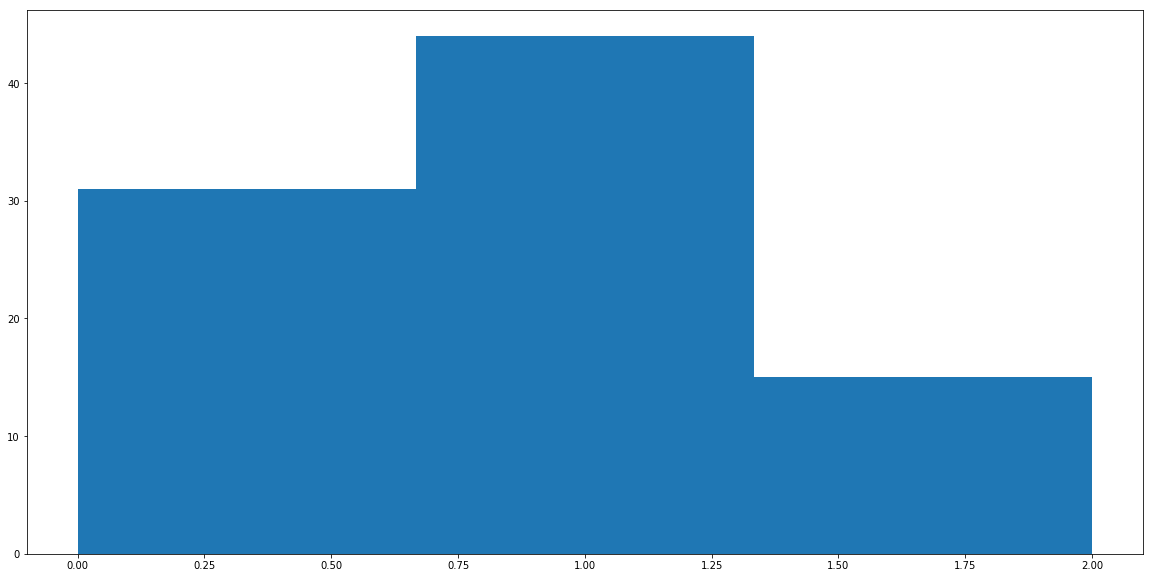

In [18]:
plt.hist(sbs['bucket'], bins=3)

## convert actual performance into bucketed performance

We abstract away QB names and actual average yards / yards per game into just a series of buckets.

Ultimately, we want to end up with probability distributions for each QB type (season buckets) defining how often they will have bad, okay, good etc games (game buckets).

In [24]:
# join bucketed season performance to bucketed game performance
sg = sbs.join(gbs, key=('year', 'name'), lprefix='s_', rprefix='g_')

# get all possible season/game bucket combos as our master list
all_bucket_combos = petl.fromdicts([
    {'s_bucket': s, 'g_bucket': g}
    for s in set(sg['s_bucket'])
    for g in set(sg['g_bucket'])
])

# get counts of all existing season/game bucket combos
game_bucket_counts = sg.aggregate(('s_bucket', 'g_bucket'), len)

# generate counts for all season/game bucket combos and fill in
# any missing values with 0
all_game_bucket_counts = (
    all_bucket_combos
    .leftjoin(
        game_bucket_counts, 
        key=('s_bucket', 'g_bucket'), 
        missing=0,
    )
    .rename({'value': 'g_count'})
)

# calculate season bucket counts
s_bucket_game_counts = (
    all_game_bucket_counts
    .aggregate('s_bucket', sum, 'g_count')
    .rename({'value': 's_count'})
)

# get probs for each season-game turnout
g_bucket_probs = (
    all_game_bucket_counts
    .join(s_bucket_game_counts, key=('s_bucket'))
    .addfield('prob', lambda r: r['g_count'] / r['s_count'])
    .cut(('s_bucket', 'g_bucket', 'g_count', 's_count', 'prob'))
)
    

# peep it
g_bucket_probs.lookall()

+----------+----------+---------+---------+----------------------+
| s_bucket | g_bucket | g_count | s_count | prob                 |
+==========+==========+=========+=========+======================+
|        0 |        0 |      15 |     496 |  0.03024193548387097 |
+----------+----------+---------+---------+----------------------+
|        0 |        1 |     218 |     496 |  0.43951612903225806 |
+----------+----------+---------+---------+----------------------+
|        0 |        2 |     218 |     496 |  0.43951612903225806 |
+----------+----------+---------+---------+----------------------+
|        0 |        3 |      43 |     496 |  0.08669354838709678 |
+----------+----------+---------+---------+----------------------+
|        0 |        4 |       2 |     496 | 0.004032258064516129 |
+----------+----------+---------+---------+----------------------+
|        1 |        0 |       8 |     704 | 0.011363636363636364 |
+----------+----------+---------+---------+-------------------

## generate list of dictionaries of raw bucketed data

We'll use this to pass into our model.

In [25]:
# generate well-formed season-game raw data

season_dicts = petl.dicts(sbs)
game_dicts = petl.dicts(gbs)

data = []

for s in season_dicts:
    gd = [
        {
            k:v for k,v in x.items()
            if k in ['yards', 'week', 'bucket']
        }
        for x in game_dicts 
        if x['year'] == s['year']
        and x['name'] == s['name']
    ]
    
    data.append(dict(
        season=s,
        games=sorted(gd, key=lambda r: r['week']),
    ))
    
data[0]

## generate likelihood and prior

The likelihood is the distribution of game performance for each QB type.

The prior is the initial guess at what type of QB the given player is that we'll analyze.

In [27]:
# generate likelihood and prior

s_bucket_dicts = list(petl.dicts(s_bucket_probs))
g_bucket_dicts = list(petl.dicts(g_bucket_probs))

season_buckets = sorted(set(s['s_bucket'] for s in s_bucket_dicts))

likelihoods = {
    sb: bayes.Pdf({
        gb['g_bucket']: gb['prob']
        for gb in g_bucket_dicts
        if gb['s_bucket'] == sb
    })
    for sb in season_buckets
}

prior = {s['s_bucket']: s['s_prob'] for s in s_bucket_dicts}

## run analysis on all players

For each player-season, run their performance through our model and log how the prior is updated (and consequently, how the posterior predictive is updated).

In [29]:
runs = []

for d in data:
    
    print(d['season']['year'], d['season']['name'])
    
    # list of actual values
    vals = [g['bucket'] for g in d['games']]
    
    dist = bayes.DiscreteBayes(
        prior=bayes.Pdf(dict(prior)),
        likelihoods=dict(likelihoods),
    )
    
    results = []

    # pre-season
    results.append({
        'prior': dict(dist.prior.probs),
        'posterior_predictive': list(dist.posterior_predictive().probs.values()),
    })

    # track bayesian results week by week
    for val in vals:
        # given number of tds this week, update our prior
        dist.update_prior(val)
        # store results
        results.append({
            'prior': dict(dist.prior.probs),
            'posterior_predictive': list(dist.posterior_predictive().probs.values()),
        })
        
    runs.append({
        'data': d,
        'vals': vals,
        'results': results,
    })

2009 Aaron Rodgers
2009 Carson Palmer
2009 Eli Manning
2009 Joe Flacco
2009 Matt Schaub
2009 Philip Rivers
2009 Tom Brady
2010 Carson Palmer
2010 Drew Brees
2010 Eli Manning
2010 Joe Flacco
2010 Matt Ryan
2010 Matt Schaub
2010 Philip Rivers
2010 Sam Bradford
2010 Tom Brady
2011 Alex Smith
2011 Andy Dalton
2011 Cam Newton
2011 Drew Brees
2011 Eli Manning
2011 Joe Flacco
2011 Mark Sanchez
2011 Matt Ryan
2011 Matthew Stafford
2011 Philip Rivers
2011 Ryan Fitzpatrick
2011 Tom Brady
2012 Aaron Rodgers
2012 Andrew Luck
2012 Andy Dalton
2012 Cam Newton
2012 Drew Brees
2012 Eli Manning
2012 Joe Flacco
2012 Matt Ryan
2012 Matt Schaub
2012 Matthew Stafford
2012 Philip Rivers
2012 Russell Wilson
2012 Ryan Fitzpatrick
2012 Ryan Tannehill
2012 Sam Bradford
2012 Tom Brady
2013 Andrew Luck
2013 Andy Dalton
2013 Ben Roethlisberger
2013 Cam Newton
2013 Carson Palmer
2013 Drew Brees
2013 Eli Manning
2013 Geno Smith
2013 Joe Flacco
2013 Matt Ryan
2013 Matthew Stafford
2013 Philip Rivers
2013 Russell Wils